In [ ]:
#!pip install fastai -q --upgrade

In [1]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.metrics import error_rate
from fastai.callback.tracker import SaveModelCallback
import argparse

In [2]:
from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import torchvision.transforms as T
import torch

from PIL import Image
import requests

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn

import ipywidgets as widgets
from IPython.display import display, clear_output
import math

In [1]:
256/16

16.0

In [3]:
#parser = argparse.ArgumentParser()
#parser.add_argument("--local_rank", type=int)
#args = parser.parse_args()

In [4]:
#torch.cuda.set_device(args.local_rank)

In [5]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #print(device)
else:
    print("No CUDA")

CUDA Available


In [8]:
beta = -1e-6
gamma = 3e-3
sigma = 1.2

def Generator_Attention_loss(preds,target,beta=beta): 

    LCA = Curating_of_attention_loss()
    Latt = beta*LCA(preds[2])

    return Latt

def Critic_Attention_loss(preds,target,beta=beta): 

    LCA = Curating_of_attention_loss()
    Latt = -1*(beta*LCA(preds[2]))

    return Latt

def Adversarial_loss(preds,target,gamma=gamma): 

    crossEntropy = nn.CrossEntropyLoss()
    classLoss = -1*(gamma*crossEntropy(preds[0], target))

    return classLoss

def Reconstruction_Loss(preds,target,sigma=sigma):
    
    MSE = nn.MSELoss()
    Lrec = sigma*MSE(preds[4],preds[3])
    
    return Lrec

In [9]:
from models.backbone import Backbone, EmbeddingNetwork
from models.encoder import EncoderModule
from models.utils.joiner3 import *
from models.utils.losses import *
from models.unet import UNet

In [10]:
model_dir = Path.home()/'Luiz/saved_models'
net = load_learner(model_dir/'IMAGENETTE_2_-1e6_3e3_1p2_36_Resnet101_GAN.pkl', cpu=False)

In [11]:
model = net.model.eval()
model = model.to(device)

In [12]:
H = 224
W= 224

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform2 = T.Compose([
T.Resize((H,W)),
T.ToTensor()
])

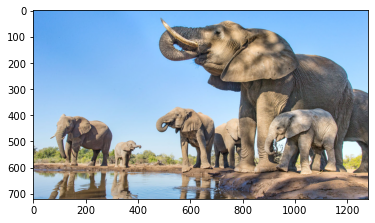

In [13]:
url1 = 'https://ogden_images.s3.amazonaws.com/www.timesrepublican.com/images/2019/05/02231710/Fox-WEB-1100x739.jpg'
url2 = 'https://cms.qz.com/wp-content/uploads/2019/12/airplane-e1575485422322.jpg?quality=75&strip=all&w=1200&h=900&crop=1'
url3 = 'https://autocar.com.ph/wp-content/uploads/2018/01/Ayrton_Senna_-_Mclaren_MP4-8_during_practice_for_the_1993_British_Grand_Prix_32873580103.jpg'
url4 = 'https://static.scientificamerican.com/sciam/cache/file/ACF0A7DC-14E3-4263-93F438F6DA8CE98A_source.jpg?w=590&h=800&896FA922-DF63-4289-86E2E0A5A8D76BE1'
url5 = 'https://www.sciencemag.org/sites/default/files/styles/article_main_large/public/elephant_1280p.jpg?itok=UT_i17Yh'
url6 = 'https://southernboating.com/wp-content/uploads/2019/11/New-running-530-0832-1024x600.jpg'
IMG_URL = url5
im = Image.open(requests.get(IMG_URL, stream=True).raw)
plt.plot()
plt.imshow(im)

In [14]:
img = transform2(im).unsqueeze(0).to(device)
print("Input shape:", img.shape)

Input shape: torch.Size([1, 3, 224, 224])


In [15]:
model.noise_mode = True
outputs, sattn, pattn, original, noise = model(img.to(device))
model.noise_mode = False
outputs2, sattn2, pattn2, original2, noise2 = model(img.to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


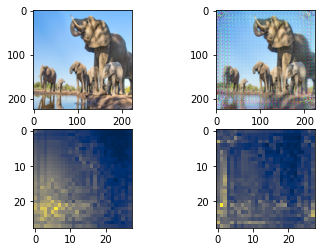

In [25]:
pix_h = 10
pix_w = 20
threshold = torch.sum(sattn[0,pix_h,pix_w,...])/1#6.3665e-38
plt.subplot(221)
plt.imshow(img[0].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(noise[0,...].cpu().detach().permute(1, 2, 0).numpy())
plt.subplot(223)
plt.imshow(sattn2[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')#,vmax=threshold)
plt.subplot(224)
plt.imshow(sattn[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')#,vmax=threshold)

In [17]:
for param in model.parameters():
    param.requires_grad = False

In [18]:
#test_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 5, shuffle=False)

Files already downloaded and verified


In [17]:
criterion = CriticLoss()

In [18]:
test_noised_loss = 0.0
test_noised_corrects = 0.0
test_running_loss = 0.0
test_running_corrects = 0.0


with torch.no_grad(): # to save memory (temporalely set all the requires grad to be false)
    model.noise_mode = False
    for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device) # allow gpu use
        test_labels = test_labels.to(device) # allow gpu use
        test_outputs, test_sattn, test_pattn, test_original, test_image = model(test_inputs) #passes the image through the network and get the output
        #print(test_outputs.shape)
        #print(test_labels.shape)
        #test_loss = criterion(test_outputs, test_labels) #compare output and labels to get the loss 

        _, test_preds = torch.max(test_outputs, 1) #same as for training
        #test_running_loss += test_loss.item() #same as for training
        test_running_corrects += torch.sum(test_preds == test_labels.data) #same as for training
        
    model.noise_mode = True
    for test_inputs, test_labels in test_loader:
        noise_inputs = test_inputs.to(device) # allow gpu use
        noise_labels = test_labels.to(device) # allow gpu use
        noise_outputs, noise_sattn, noise_pattn, noise_original, noise_image = model(noise_inputs) #passes the image through the network and get the output
        #noise_loss = criterion(noise_outputs, noise_labels) #compare output and labels to get the loss 

        _, noise_preds = torch.max(noise_outputs, 1) #same as for training
        #test_noised_loss += noise_loss.item() #same as for training
        test_noised_corrects += torch.sum(noise_preds == noise_labels.data) #same as for training


#TRAINING LOSS AND ACCURACY
epoch_loss = test_running_loss/len(test_dataset) # the sum of the loss of all itens divided by the number of itens
epoch_acc = test_running_corrects.float()/ len(test_dataset) # the sum of correct predictions divided by the number of itens


#VALIDATION LOSS AND ACCURACY
noise_epoch_loss = test_noised_loss/len(test_dataset)
noise_epoch_acc = test_noised_corrects.float()/ len(test_dataset)
print('Original Image loss acc {:.4f}'.format(epoch_acc.item()))
print('Noised Image acc {:.4f} '.format(noise_epoch_acc.item()))

KeyboardInterrupt: 

In [20]:
class AttentionVisualizer:
    def __init__(self, model, transform):
        self.model = model
        self.transform = transform

        self.url = ""
        self.cur_url = None
        self.pil_img = None
        self.tensor_img = None

        self.conv_features = None
        self.enc_attn_weights = None
        self.dec_attn_weights = None

        self.setup_widgets()

    def setup_widgets(self):
        self.sliders = [
            widgets.Text(
                value=IMG_URL,
                placeholder='Type something',
                description='URL (ENTER):',
                disabled=False,
                continuous_update=False,
                layout=widgets.Layout(width='100%')
            ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='X coordinate', value=0.72,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')
                        ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='Y coordinate', value=0.40,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')),
            widgets.Checkbox(
              value=False,
              description='Direction of self attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          ),
            widgets.Checkbox(
              value=True,
              description='Show red dot in attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          )
        ]
        self.o = widgets.Output()

    def compute_features(self, img):
        model = self.model
        # use lists to store the outputs via up-values
        #outputs, sattn, pattn = model(img.to(device))
        conv_features, enc_attn_weights, dec_attn_weights, _, _ = model(img.to(device))

        #hooks = [
        #    model.backbone[-2].register_forward_hook(
        #        lambda self, input, output: conv_features.append(output)
        #    ),
        #    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        #        lambda self, input, output: enc_attn_weights.append(output[1])
        #    ),
        #    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        #        lambda self, input, output: dec_attn_weights.append(output[1])
        #    ),
        #]
        # propagate through the model
        #outputs = model(img)

        #for hook in hooks:
        #    hook.remove()

        # don't need the list anymore
        self.conv_features = conv_features
        self.dec_attn_weights = dec_attn_weights
        # get the HxW shape of the feature maps of the CNN
        #print(enc_attn_weights.shape)
        shape = enc_attn_weights.shape[-2:]
        # and reshape the self-attention to a more interpretable shape
        self.enc_attn_weights = enc_attn_weights[0].reshape(shape + shape)
        #print(self.enc_attn_weights.shape)
    
    def compute_on_image(self, url):
        if url != self.url:
            self.url = url
            self.pil_img = Image.open(requests.get(url, stream=True).raw)
            # mean-std normalize the input image (batch-size: 1)
            self.tensor_img = self.transform(self.pil_img).unsqueeze(0)
            self.compute_features(self.tensor_img)
    
    def update_chart(self, change):
        with self.o:
            clear_output()

            # j and i are the x and y coordinates of where to look at
            # sattn_dir is which direction to consider in the self-attention matrix
            # sattn_dot displays a red dot or not in the self-attention map
            url, j, i, sattn_dir, sattn_dot = [s.value for s in self.sliders]

            fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 4))
            self.compute_on_image(url)

            # convert reference point to absolute coordinates
            j = int(j * self.tensor_img.shape[-1])
            i = int(i * self.tensor_img.shape[-2])

            # how much was the original image upsampled before feeding it to the model
            scale = self.pil_img.height / self.tensor_img.shape[-2]

            # compute the downsampling factor for the model
            # it should be 32 for standard DETR and 16 for DC5
            sattn = self.enc_attn_weights
            fact = 2 ** round(math.log2(self.tensor_img.shape[-1] / sattn.shape[-1]))

            # round the position at the downsampling factor
            x = ((j // fact) + 0.5) * fact
            y = ((i // fact) + 0.5) * fact

            axs[0].imshow(self.pil_img)
            axs[0].axis('off')
            axs[0].add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))

            idx = (i // fact, j // fact)
            
            if sattn_dir:
                sattn_map = sattn[idx[0], idx[1], ...]
                threshold = torch.sum(sattn_map)/100
            else:
                sattn_map = sattn[idx[0], idx[1],...]
                threshold = torch.sum(sattn_map)/100
            axs[1].imshow(sattn_map.cpu(), cmap='cividis', interpolation='nearest',vmax=threshold)
            if sattn_dot:
                axs[1].add_patch(plt.Circle((idx[1],idx[0]), 1, color='r'))
            axs[1].axis('off')
            axs[1].set_title(f'self-attention{(i, j)}')

            plt.show()
        
    def run(self):
      for s in self.sliders:
          s.observe(self.update_chart, 'value')
      self.update_chart(None)
      url, x, y, d, sattn_d = self.sliders
      res = widgets.VBox(
      [
          url,
          widgets.HBox([x, y]),
          widgets.HBox([d, sattn_d]),
          self.o
      ])
      return res

In [21]:
w = AttentionVisualizer(model, transform)
w.run()